<a href="https://colab.research.google.com/github/ekolmagorov/FailureForecasting/blob/main/ST_UNET_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import torch 


from torchvision.models import resnet as resnet_modules
from torch.optim import Adam
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May 27 13:31:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
random.seed(123)

DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc4/1AY0e-g5NK5WsDAYsKgpSmzdSWB2ZEAyHPG5Vwo9U7oLE0-Wrg19cnzv13zc

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
% cd /content/drive/MyDrive/курсовая
#! ls

/content/drive/MyDrive/курсовая


In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [7]:
def init_model(model_name, pretrained=False):
    
    if model_name == 'resnet':
        resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=pretrained)
        length = len(list(resnet.children()))
        od = OrderedDict()
        for index, (name, val) in enumerate(resnet.named_children()):
            if index == length - 2:
                break
            if isinstance(val, nn.BatchNorm2d):
                val = Identity()
                
            if isinstance(val, nn.Sequential):
                for ch_name, ch_val in val.named_children():
                    if isinstance(ch_val, resnet_modules.BasicBlock):
                        ch_val.bn1 = Identity()
                        ch_val.bn2 = Identity()
                        if hasattr(ch_val, 'downsample'):
                            downsample = getattr(ch_val, 'downsample')
                            if isinstance(downsample, nn.Sequential):
                                downsample[1]= Identity()
            
            od[name] = val

        od['maxpool2'] = nn.MaxPool2d(2)
        od['conv2'] = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        od['relu2'] = nn.ReLU()
        od['maxpool3'] = nn.MaxPool2d(2)

        model = nn.Sequential(od)

        layers =  ['relu', 'layer1', 'layer2', 'layer3', 'layer4', 'relu2']
        
        channels_sizes = [(512, 512),
                          (512, 512),
                          (512, 256),
                          (256, 128),
                          (128, 64),
                          (64, 64)]

    elif model_name == 'vgg' :
        model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=pretrained).features
        layers = ['1', '6', '11', '18', '25']
        channels_sizes = [(512, 512),
                        (512, 512),
                        (512, 256),
                        (256, 128),
                        (128, 64)]


    return model, layers, channels_sizes

In [8]:
model, LAYERS_NAME, CHANNELS_SIZES = init_model('vgg', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [9]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
#vgg = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).features

In [11]:
#vgg

In [12]:
example_tensor = torch.randn((1, 3, 256, 256))
out = model(example_tensor)
out.shape

torch.Size([1, 512, 8, 8])

In [13]:
class EncoderBlock(nn.Module):

    '''
    Encoder part in Unet-style neural network model
    '''

    def __get_activation(self, name):
        def __hook(module, input, output):
            self.output[name] = output

        return __hook


    def __init__(self, encoder_model, output_layers=None, requires_grad=True):
      super(EncoderBlock, self).__init__()

      self.model = encoder_model
      for param in self.model.parameters():
        param.requires_grad = requires_grad
        
      self.output_layers = output_layers
      self.output = {}

      if output_layers is not None:
        
        for idx, layer_name in enumerate(output_layers):

          if not hasattr(self.model, layer_name):
            raise KeyError("such {} in your encoder model doesn't exist".
                           format(layer_name))

          getattr(self.model, layer_name).register_forward_hook(
              self.__get_activation(layer_name)
              )


    def forward(self, x):

      self.output.clear()
      out = self.model(x)
      self.output['out'] = out
      return out, self.output.copy()

In [14]:
encoder = EncoderBlock(model, LAYERS_NAME)

In [15]:
example_tensor = torch.randn((2, 3, 1024, 1024))
out, d_out = encoder(example_tensor)

In [16]:
for key, value in d_out.items():
    print(key, value.shape)

1 torch.Size([2, 64, 1024, 1024])
6 torch.Size([2, 128, 512, 512])
11 torch.Size([2, 256, 256, 256])
18 torch.Size([2, 512, 128, 128])
25 torch.Size([2, 512, 64, 64])
out torch.Size([2, 512, 32, 32])


In [17]:
class AdainBlock(nn.Module):

    def __init__(self, layers_names):
        super(AdainBlock, self).__init__()
        self.layers_names = layers_names
        self.outputs = {}

    def transform(self, content, style):
        content_size, style_size = content.size(), style.size()
        content_sigma = torch.std(content, dim=(2, 3), keepdims=True)#.expand(content_size)
        style_sigma = torch.std(style, dim=(2, 3), keepdims=True)#.expand(style_size)

        content_mu = torch.mean(content, dim=(2, 3), keepdims=True)#.expand(content_size)
        style_mu = torch.mean(style, dim=(2, 3), keepdims=True)#.expand(style_size)

        
        out = style_sigma * ((content - content_mu)/ (content_sigma + 1e-5)) + style_mu

        return  out

    def forward(self, content_features, style_features):

        self.outputs.clear()

        for layer_name in self.layers_names:

            self.outputs[layer_name] = self.transform(
                                              content_features[layer_name],
                                              style_features[layer_name])
            
        return self.outputs.copy()


In [18]:
example_tensor_c = torch.randn((1, 3, 256, 256))
example_tensor_s = torch.randn((1, 3, 256, 256))

adain = AdainBlock(LAYERS_NAME)

out_c, d_out_c = encoder(example_tensor_c)
out_s, d_out_s = encoder(example_tensor_s)

outputs = adain(d_out_c, d_out_s)
out = adain.transform(out_c, out_s)
for name, value in outputs.items():
    print("name: {}, shape: {}".format(name, value.shape))
print("out shape:", out.size())

name: 1, shape: torch.Size([1, 64, 256, 256])
name: 6, shape: torch.Size([1, 128, 128, 128])
name: 11, shape: torch.Size([1, 256, 64, 64])
name: 18, shape: torch.Size([1, 512, 32, 32])
name: 25, shape: torch.Size([1, 512, 16, 16])
out shape: torch.Size([1, 512, 8, 8])


In [19]:
#print(outputs)

In [20]:
'''
out_height, out_width = out.shape[-2:]
skip_height, skip_width = skip_feature.shape[-2:]

out_height_pad = out_height - max(out_height, skip_height)
out_width_pad = out_width - max(out_width, skip_width)

skip_height_pad = skip_height - max(out_height, skip_height)
skip_width_pad = skip_width - max(out_width, skip_width)

out = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)
skip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)
d'''

'\nout_height, out_width = out.shape[-2:]\nskip_height, skip_width = skip_feature.shape[-2:]\n\nout_height_pad = out_height - max(out_height, skip_height)\nout_width_pad = out_width - max(out_width, skip_width)\n\nskip_height_pad = skip_height - max(out_height, skip_height)\nskip_width_pad = skip_width - max(out_width, skip_width)\n\nout = nn.ZeroPad2d((out_height_pad, 0, out_width_pad))(out)\nskip_feature = nn.ZeroPad2d((skip_height_pad, 0, skip_width_pad))(skip_feature)\nd'

In [21]:
def crop_tensors(first, second):
    first_height, first_width = first.shape[-2:]
    second_height, second_width = second.shape[-2:]

    min_height = min(first_height, second_height)
    min_width = min(first_width, second_width)

    first = first[:, :, :min_height, :min_width]
    second = second[:, :, :min_height, :min_width]

    return first, second


class DecoderBlock(nn.Module):
  
    def createDecoderBlock(self, in_channels, out_channels, kernel_size=3,
                           stride=1, scale_factor=2):
        
        
        decoder_block = nn.Sequential(OrderedDict([
             
            ('upsample', nn.Upsample(scale_factor=scale_factor)),
            ('conv1', nn.Conv2d(in_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding=1)),
            ]))
        
        '''
        decoder_block = nn.ConvTranspose2d(in_channels,
                                           out_channels,
                                           kernel_size=3,
                                           stride=2,
                                           padding=1,
                                           output_padding=1)
    
        '''
        return decoder_block
        
    def createFusionBlock(self, in_channels, out_channels, kernel_size=3, stride=1):
        fusion_block =  nn.Sequential(nn.Conv2d(in_channels,
                                                 out_channels,
                                                 kernel_size=kernel_size,
                                                 stride=1,
                                                 padding=1),
                                       nn.LeakyReLU(0.2))
        
        return fusion_block


    def __init__(self, channels_sizes):

        super(DecoderBlock, self).__init__()
        self.decoder_channels = channels_sizes
        
        self.decoder_layers = nn.ModuleList(
            [self.createDecoderBlock(c_size_in, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        
        
        
        self.fusion_layers = nn.ModuleList(
            [self.createFusionBlock(2*c_size_out, c_size_out) 
            for (c_size_in, c_size_out) in channels_sizes])
        self.last_decoder_layer = self.createDecoderBlock(channels_sizes[-1][-1], 3, scale_factor=1)

        #self.last_layer_act = nn.ReLU()#nn.Sigmoid()

    def forward(self, out, skip_features):

        skip_features = skip_features[::-1]


        for idx, skip_feature in enumerate(skip_features):

            
            out = nn.LeakyReLU(0.2)(self.decoder_layers[idx](out))
            out, skip_feature = crop_tensors(out, skip_feature)
            #print(out.shape, skip_feature.shape)
            out = self.fusion_layers[idx](torch.cat((out, skip_feature), dim=1))
            #out = skip_feature + out
            #out = self.fusion_layers[idx](out)

        out = self.last_decoder_layer(out)

        return nn.Sigmoid()(out)

In [22]:


decoder = DecoderBlock(CHANNELS_SIZES)

channels_orders = {i: l_name
                   for i, l_name in enumerate(LAYERS_NAME)} 

skip_features = [outputs[channels_orders[i]]
                 for i in range(len(channels_orders))]

x = decoder(out, skip_features)
x.shape

torch.Size([1, 3, 256, 256])

In [23]:
class STUNet(nn.Module):

    def __init__(self, encoder_block, adain_block, decoder_block,
                 skip_layers, features_sizes):

          super(STUNet, self).__init__()
          self.skip_layers = skip_layers
          self.encoder_model = EncoderBlock(encoder_block, skip_layers, requires_grad=True)
          self.adain_model = AdainBlock(skip_layers)
          self.decoder_model = DecoderBlock(features_sizes)

          #self.weights = nn.ParameterList([nn.Parameter(torch.ones(1, requires_grad=False), requires_grad=False)
          #                                 for i in range(len(skip_layers) + 1)])
          self.weights = [ 1 for i in range(len(skip_layers) + 1) ]
          
          self.dropouts = [ nn.Dropout(p=max(0.6-0.2 * i, 0), inplace=True)
                           for i in range(len(skip_layers))]
    
    def reset_weights(self):
        self.weights = [ 1 for i in range(len(self.skip_layers) + 1) ]
        self.dropout.p = 0.5

    def forward(self, content_images, style_images):

        enc_out_c, enc_d_out_c = self.encoder_model(content_images)
        enc_out_s, enc_d_out_s = self.encoder_model(style_images)
        #print(enc_d_out_c, enc_d_out_s)
        adain_out  = adain.transform(enc_out_c, enc_out_s) 
        adain_outs = adain(enc_d_out_c, enc_d_out_s)

        skip_features = [self.weights[i] * self.dropouts[i](adain_outs[channels_orders[i]])
                 for i in range(len(channels_orders))]

        adain_out = adain_out * self.weights[-1]

        out = self.decoder_model(adain_out, skip_features)


        return out
    

In [24]:
#resnet = nn.Sequential(od)
adain = AdainBlock(LAYERS_NAME)
decoder = DecoderBlock(CHANNELS_SIZES)


main_model = STUNet(model, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [25]:
example_tensor_c = torch.randn((1, 3, 512, 512))
example_tensor_s = torch.randn((1, 3, 512, 512))

x = main_model(example_tensor_c, example_tensor_s)
x.shape

torch.Size([1, 3, 512, 512])

In [26]:
x.shape

torch.Size([1, 3, 512, 512])

In [27]:
print(main_model)

STUNet(
  (encoder_model): EncoderBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [28]:
class STDataSet(Dataset):

    def __init__(self, content_filenames, style_filenames, get_random=True, **kwargs):
        self.style_filenames = style_filenames
        self.content_filenames = content_filenames

        self.get_random = get_random
        self.kwargs = kwargs
      
        if not self.get_random:
            l_style = len(self.style_filenames)
            l_content = len(self.content_filenames)

            styles_filenames = [
                                     self.style_filenames[i]
                                     for i in range(len(self.style_filenames))
                                     for j in range(len(self.content_filenames))
                                    ]

            content_filenames = [
                                      self.content_filenames[j]
                                      for i in range(len(self.style_filenames))
                                      for j in range(len(self.content_filenames))
                                      ]

            self.train_set = list(zip(content_filenames, styles_filenames))
        

    def __len__(self):
      return len(self.style_filenames) * len(self.content_filenames)
    
    def get_names(self, idx):

        if not self.get_random:
            return self.train_set[idx]
        else:
            return None

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
            idx = idx.tolist()
    
      if self.get_random:
          content_filename = self.content_filenames[
                                random.randint(0, len(self.content_filenames)-1)
                                ]

          style_filename = self.style_filenames[
                                random.randint(0, len(self.style_filenames)-1)
                                ]
         
      else:
          content_filename, style_filename = self.train_set[idx]

      content, style = Image.open(content_filename), Image.open(style_filename)

      if 'content_transform' in self.kwargs:
          content = self.kwargs['content_transform'](content)
      
      if 'style_transform' in self.kwargs:
          style = self.kwargs['style_transform'](style)
      #print(style.shape)
      return (content, style)

In [29]:
#-------------------------------------------------------------------------------
contents_dir_train = 'target_dataset/Contents'
styles_dir_train = 'target_dataset/Styles'
#-------------------------------------------------------------------------------


content_filenames_train = [os.path.join(contents_dir_train, filename)
                          for filename in os.listdir(contents_dir_train)]

style_filenames_train = [os.path.join(styles_dir_train, filename) 
                        for filename in  os.listdir(styles_dir_train)]

In [30]:
#-------------------------------------------------------------------------------
contents_dir_test = 'target_dataset/articles_contents'
styles_dir_test = 'target_dataset/articles_styles'
#-------------------------------------------------------------------------------


content_filenames_test = [os.path.join(contents_dir_test, filename)
                          for filename in os.listdir(contents_dir_test)]

style_filenames_test = [os.path.join(styles_dir_test, filename) 
                        for filename in  os.listdir(styles_dir_test)]

In [31]:
size = (512, 512)
content_transform = transforms.Compose([transforms.Resize(size),
                                        transforms.ToTensor(),
                                        ])

style_transform = transforms.Compose([transforms.Resize(size),
                                      transforms.ToTensor(),])

dataset_train = STDataSet(content_filenames_train,
                          style_filenames_train,
                          style_transform=style_transform,
                          content_transform=content_transform,
                          get_random=False)

dataset_test = STDataSet(content_filenames_test,
                         style_filenames_test,
                         style_transform=style_transform,
                         content_transform=content_transform,
                         get_random=False)





#fig, axes = plt.subplots(1,2, figsize=(15, 15))
#axes[0].imshow(content)
#axes[1].imshow(style)

In [32]:
content, style = dataset_train[2]
print(content.shape, style.shape)

torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


In [33]:
#from IPython.display import display # to display images
#display(transforms.ToPILImage()(content))

In [34]:
class TransformerLoss(EncoderBlock):

    def __init__(self, encoder_model, output_layers=None, weights=None,
                 requires_grad=False, resize_factor=None):
        if weights is not None:
            assert len(output_layers) == len(weights)

        self.weights = weights

        super(TransformerLoss, self).__init__(encoder_model, output_layers)
        self.resize_factor = resize_factor
        if resize_factor:
            self.pool = nn.AvgPool2d(resize_factor)

        for param in self.model.parameters():
            param.requires_grad = requires_grad


    @staticmethod
    def compute_gram_matrix_loss(first_tensor, second_tensor):

        n, c, h, w = first_tensor.shape
        first_tensor = first_tensor.view(n, c, -1)
        second_tensor = second_tensor.view(n, c, -1)

        G1 = torch.bmm(first_tensor, first_tensor.transpose(2, 1))
        G2 = torch.bmm(second_tensor, second_tensor.transpose(2, 1))

        loss = torch.sum((G1 - G2) ** 2) / ((2 * h * w  * c) ** 2 * n) 

        return loss


    @staticmethod
    def compute_style_loss(first_tensor, second_tensor):
        first_tensor_mean = torch.mean(first_tensor, dim=(-1, -2))
        second_tensor_mean = torch.mean(second_tensor, dim=(-1, -2))

        mu_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_mean - second_tensor_mean) ** 2, dim=-1)
            ))

        first_tensor_std = torch.std(first_tensor, dim=(-1, -2))
        second_tensor_std = torch.std(second_tensor, dim=(-1, -2))

        std_diff = torch.mean(torch.sqrt(
            torch.sum((first_tensor_std - second_tensor_std) ** 2, dim=-1)
            ))


        total_diff = mu_diff + std_diff
 
        return total_diff

    @staticmethod
    def compute_content_loss(first_tensor, second_tensor):
        
        #n, c, h, w = first_tensor_shape
        #first_tensor = first.tensor()
        #tensor_diff = torch.mean(torch.sqrt(
        #      torch.sum((first_tensor - second_tensor) ** 2, dim=(1,2,3))
         #     ))
        tensor_diff = nn.MSELoss()(first_tensor, second_tensor)

        return tensor_diff


    def __compute_loss(self, enc_first, enc_second, func):
        assert enc_first.keys() == enc_second.keys()


        loss = 0
        for key in self.output_layers:
            
            first_tensor, second_tensor = enc_first[key], enc_second[key]

            l = func(first_tensor, second_tensor)

            loss +=  l * self.weights[key] if self.weights[key] is not None else l
        return loss
            
            

    def __call__(self, content, style, out):
        if self.resize_factor:
            content, style, out = self.pool(content), self.pool(style), self.pool(out)

        content, out = crop_tensors(content, out)
        enc_content, enc_content_d = EncoderBlock.__call__(self, content)
        #print(enc_content_d)
        enc_style, enc_style_d = EncoderBlock.__call__(self, style)
        #print(enc_style_d)
        enc_out, enc_out_d = EncoderBlock.__call__(self, out)
        
        c_loss = self.__compute_loss(enc_out_d,
                                     enc_content_d,
                                     self.compute_content_loss)
        
        s_loss = self.__compute_loss(enc_out_d,
                                     enc_style_d,
                                     self.compute_gram_matrix_loss)

        return c_loss, s_loss

In [35]:
def tv_loss(t_tensor):
    assert len(t_tensor.shape) == 4
    height_loss = nn.MSELoss()(t_tensor[:, :, 1:, :], t_tensor[:, :, :1, :])
    width_loss = nn.MSELoss()(t_tensor[:, :, :, 1:], t_tensor[:, :,:, :1])

    return height_loss + width_loss

In [36]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True)
vgg19.features

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [37]:
weights = {
           '6':1,
           '11': 1,
           '18': 1,
           '25': 1,
           '30':1}

layers = weights.keys()
loss_model = TransformerLoss(vgg19.features,
                             layers,
                             weights,
                             False,
                             size[0]//256).eval()


content_example = torch.zeros(1, 3, 512, 512)
style_example = torch.ones(1, 3, 256, 256)
out_example = (torch.ones(1, 3, 512, 512) / 2)

c_loss, s_loss = loss_model(content_example,
                                       style_example,
                                       out_example, )

print("C_loss : {}, s_loss: {}".format(c_loss.item(), s_loss.item()))

C_loss : 0.10039154440164566, s_loss: 0.04544002190232277


In [38]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D

def plot_grad_flow_v2(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    #plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [39]:
def write_gradients(model, grad_dict):
    for n, p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n):
            ave_g, max_g = p.grad.abs().mean(),  p.grad.abs().max()
            grad_dict[n]= (grad_dict[n][0] + ave_g, grad_dict[n][1] + max_g)
    return grad_dict 

In [40]:
def normalize(tensor):
    mu = torch.Tensor([ [ [[0.485]], [[0.456]], [[0.406]] ] ]).to(DEVICE)

    std =  torch.Tensor([ [ [[0.229]], [[0.224]], [[0.225]] ] ]).to(DEVICE)

    return (tensor - mu) /std


def adjust_learning_rate(optimizer, iteration_count, lr_val, lr_decay):
    """Imitating the original implementation"""
    lr = lr_val / (1.0 +  lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [41]:
import time
count_num_params = lambda model: sum(p.numel() for p in model.parameters()
                                    if p.requires_grad)



def get_cuda_mem_info():
    t = torch.cuda.get_device_properties(0).total_memory / 1e9
    r = torch.cuda.memory_reserved(0) /1e9
    a = torch.cuda.memory_allocated(0) / 1e9

    return t, r, a

def train(model, optimizer, dataset, loss_fn, num_steps, batch_size=1, lr=1e-3, alpha=1, out_frequency=None):

    #print("Start:{},{}, {}".format(*get_cuda_mem_info()))
    model.train()
    model = model.to(DEVICE)
    #print("After model:{},{}, {}".format(*get_cuda_mem_info()))
    loss_fn = loss_fn.eval().to(DEVICE)
    #print("After loss:{},{}, {}".format(*get_cuda_mem_info()))
    num_params = count_num_params(model)
    print("Train model with: {} parameters".format(num_params))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    optimizer_base = optimizer(model.parameters(), lr=lr)
    #optimizer_weights = optimizer(model.weights, lr=1e-2)
    writer = SummaryWriter()
    #writer.add_graph(model)


    dataloader_size = len(dataloader)
    

    #normalize = nn.Sequential(transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                             std=[0.229, 0.224, 0.225]))
    c_loss, s_loss, total_loss, t_loss = 0, 0, 0, 0
    num_iters = 0
    grad_dict = {key: (0, 0) for key, _ in model.named_parameters()}
    while num_iters < num_steps:
      for idx, (contents, styles) in enumerate(dataloader):
          #print(num_iters)
          if num_iters > num_steps:
              break
        
          #adjust_learning_rate(optimizer, num_iters, lr, 1e-2)
          n_channels, style_height, style_width = styles.shape[-3:]
          #if style_height > 800 or style_width > 800 or n_channels < 3:
          #  continue


          contents, styles = contents.to(DEVICE), styles.to(DEVICE)
          contents, styles = normalize(contents), normalize(styles)

          optimizer_base.zero_grad()
          #optimizer_weights.zero_grad()

          out_img = model(contents, styles)

          content_loss, style_loss = loss_fn(contents,
                                             styles,
                                             normalize(out_img)
          )

          #total_var_loss = tv_loss(out_img)
          #t_loss += total_var_loss.item()
          loss = style_loss + alpha * content_loss #+ total_var_loss
         # hooks = register_hooks(loss)
          c_loss += content_loss.item()
          s_loss += style_loss.item()
          total_loss += loss.item()
          loss.backward()

          #torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

          optimizer_base.step()
          #optimizer_weights.step()

          num_iters += 1
         
          writer.add_scalar("ContentLoss", c_loss, num_iters)
          writer.add_scalar("StyleLoss", s_loss, num_iters)
          grad_dict  = write_gradients(model, grad_dict)

          if (out_frequency) and not (num_iters % out_frequency):
              #for n, p in model.named_parameters():
              #  print(n)
              #  print(n, p.grad.max(), p.grad.min())
              #print([p.data.item() for p in model.weights])
              plot_grad_flow_v2(model.named_parameters())
              plt.show()
              #get_hooks = hooks()
              #return get_hooks
              window_loss = total_loss / out_frequency
              c_loss = c_loss /out_frequency
              s_loss = s_loss / out_frequency
             # t_loss = t_loss / out_frequency

              print("Iter: {} | Train loss on last  {} : total - {}, content-{}, style-{}".format(num_iters,
                                                                    out_frequency,
                                                                    window_loss,
                                                                    c_loss, s_loss,
                                                                 #   t_loss
                                                                    ))
              total_loss, c_loss, s_loss = 0, 0, 0#, t_loss = 0, 0, 0, 0

    return model, writer, grad_dict

In [42]:
'''
main_model.weights = [0 for i in range(len(main_model.weights))]

main_model = train(main_model,
                  Adam,
                  dataset_train,
                  loss_model,
                  100,
                  batch_size=3,
                  lr=1e-3,
                  out_frequency=20,
                  alpha=3e-2)
'''

'\nmain_model.weights = [0 for i in range(len(main_model.weights))]\n\nmain_model = train(main_model,\n                  Adam,\n                  dataset_train,\n                  loss_model,\n                  100,\n                  batch_size=3,\n                  lr=1e-3,\n                  out_frequency=20,\n                  alpha=3e-2)\n'

Train model with: 31971715 parameters


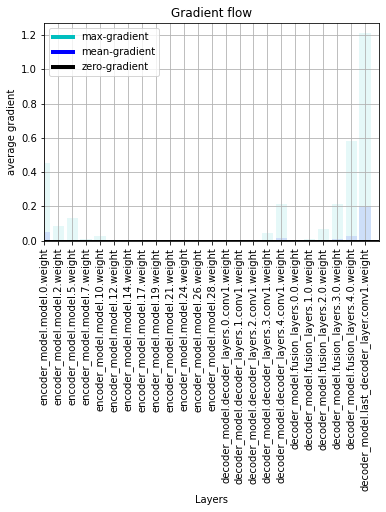

Iter: 20 | Train loss on last  20 : total - 28.4536395072937, content-33.015587997436526, style-25.152080833911896


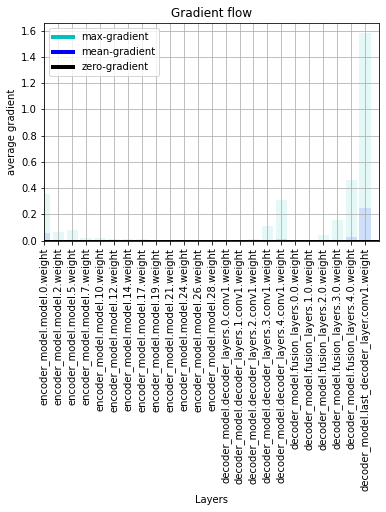

Iter: 40 | Train loss on last  20 : total - 26.49110403060913, content-30.198498249053955, style-23.471254301071166


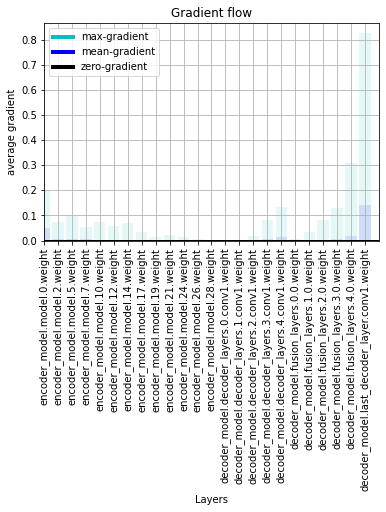

Iter: 60 | Train loss on last  20 : total - 18.60266444683075, content-29.264558124542237, style-15.676208698749543


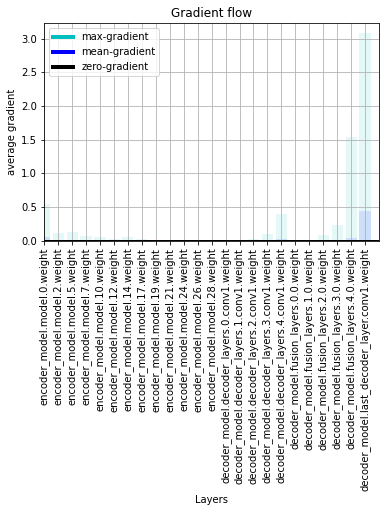

Iter: 80 | Train loss on last  20 : total - 23.030858397483826, content-27.044196224212648, style-20.32643895149231


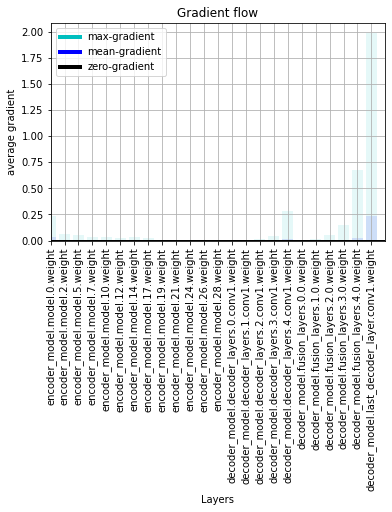

Iter: 100 | Train loss on last  20 : total - 19.408018589019775, content-27.872947692871094, style-16.620723927021025


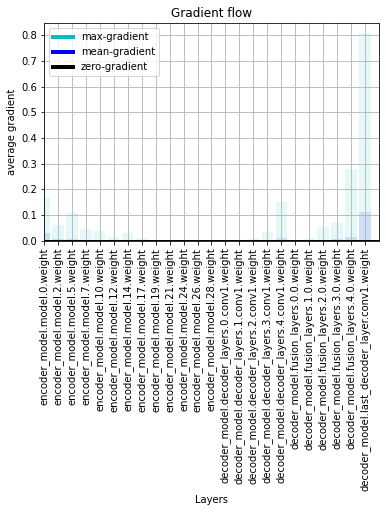

Iter: 120 | Train loss on last  20 : total - 11.431768774986267, content-22.41933403015137, style-9.18983523249626


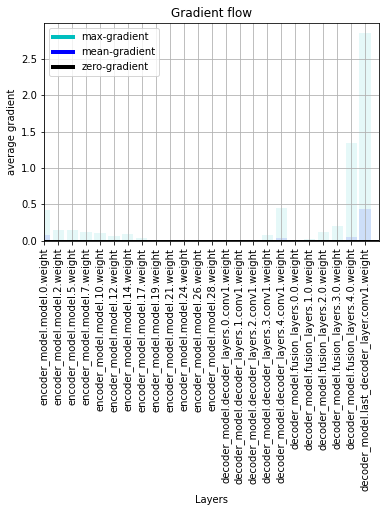

Iter: 140 | Train loss on last  20 : total - 12.235318541526794, content-24.351420974731447, style-9.80017660856247


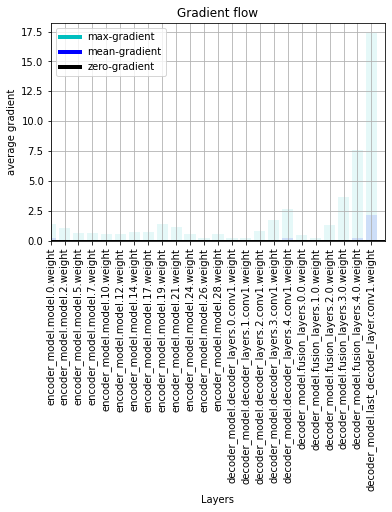

Iter: 160 | Train loss on last  20 : total - 20.132000732421876, content-23.010463142395018, style-17.830954551696777


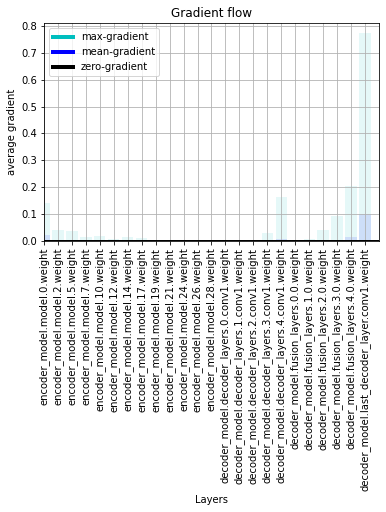

Iter: 180 | Train loss on last  20 : total - 24.232089400291443, content-21.34910969734192, style-22.097178447246552


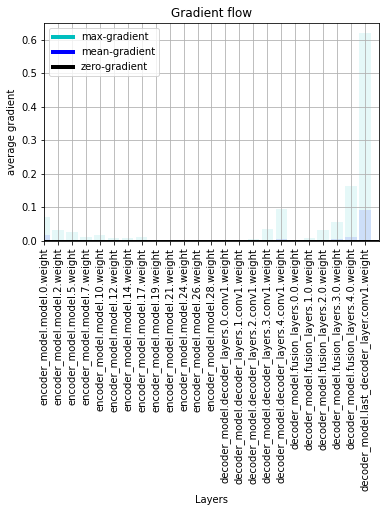

Iter: 200 | Train loss on last  20 : total - 21.502594304084777, content-23.770945692062377, style-19.125499606132507


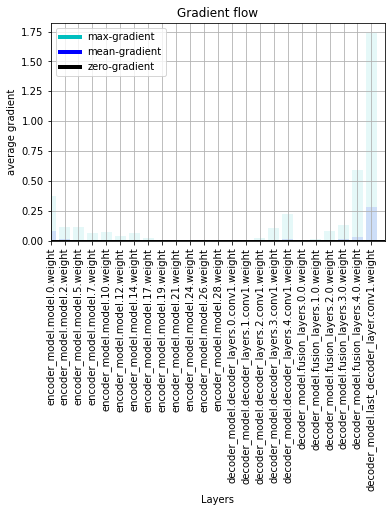

Iter: 220 | Train loss on last  20 : total - 19.283760619163512, content-21.959009885787964, style-17.087859630584717


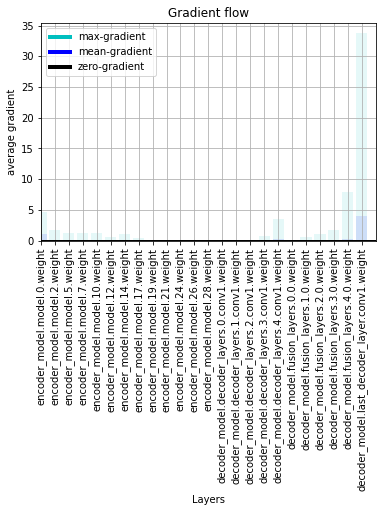

Iter: 240 | Train loss on last  20 : total - 19.939266562461853, content-23.53484926223755, style-17.585781466960906


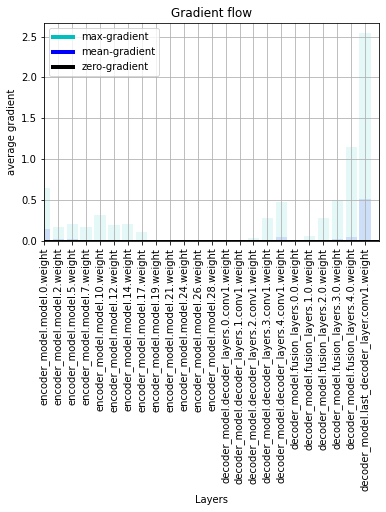

Iter: 260 | Train loss on last  20 : total - 14.65105414390564, content-20.67032446861267, style-12.584021818637847


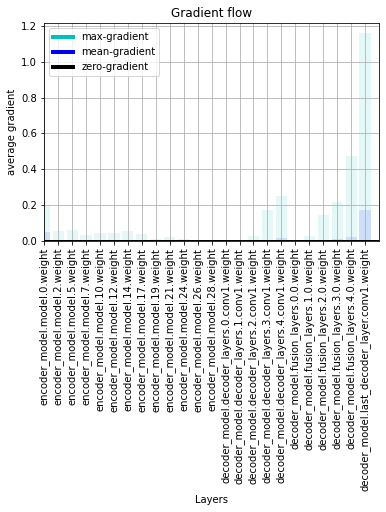

Iter: 280 | Train loss on last  20 : total - 12.729284393787385, content-21.016471338272094, style-10.627636921405792


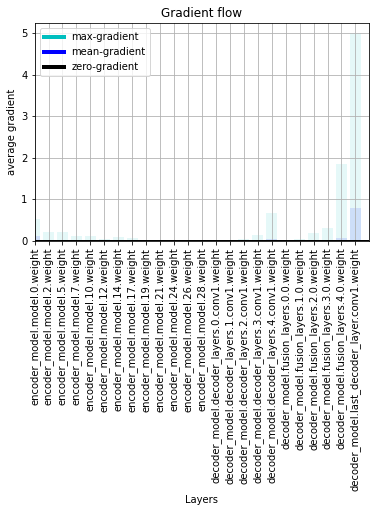

Iter: 300 | Train loss on last  20 : total - 18.30889582633972, content-22.533702182769776, style-16.055525636672975


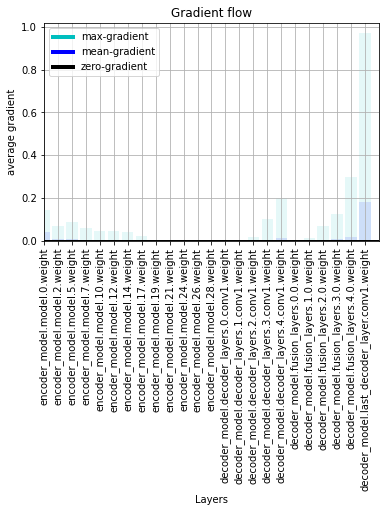

Iter: 320 | Train loss on last  20 : total - 15.580306696891785, content-23.601334047317504, style-13.220173263549805


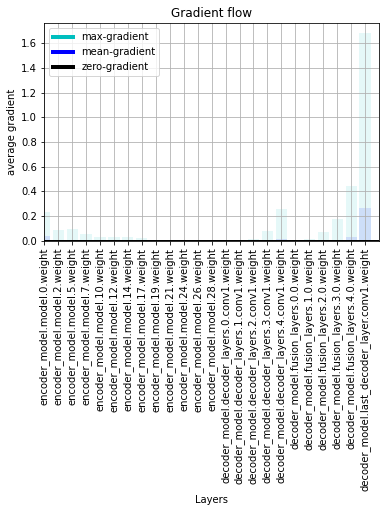

Iter: 340 | Train loss on last  20 : total - 17.0129732131958, content-23.087496709823608, style-14.704223376512527


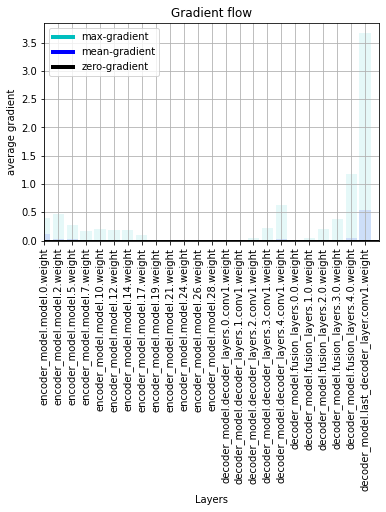

Iter: 360 | Train loss on last  20 : total - 15.425669312477112, content-22.88500666618347, style-13.137168473005294


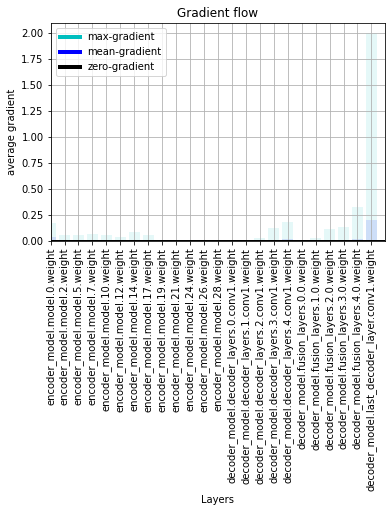

Iter: 380 | Train loss on last  20 : total - 20.964585256576537, content-26.777988338470458, style-18.286786365509034


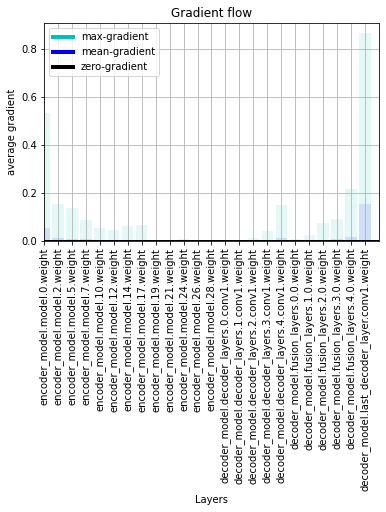

Iter: 400 | Train loss on last  20 : total - 19.047892618179322, content-25.517028427124025, style-16.49618978500366


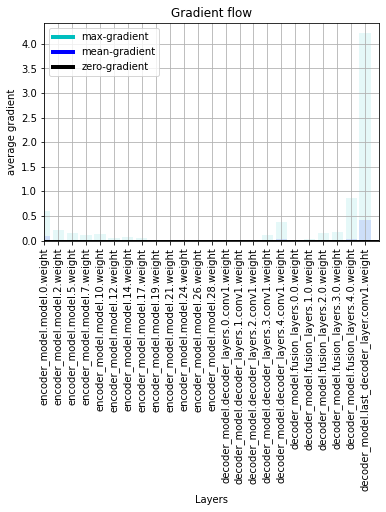

Iter: 420 | Train loss on last  20 : total - 15.565245115756989, content-25.530921268463135, style-13.012152963876725


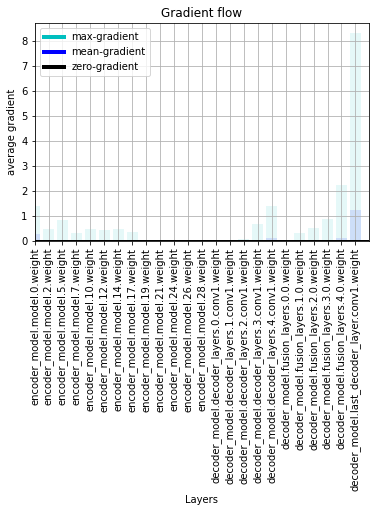

Iter: 440 | Train loss on last  20 : total - 18.079892241954802, content-26.95797481536865, style-15.384094679355622


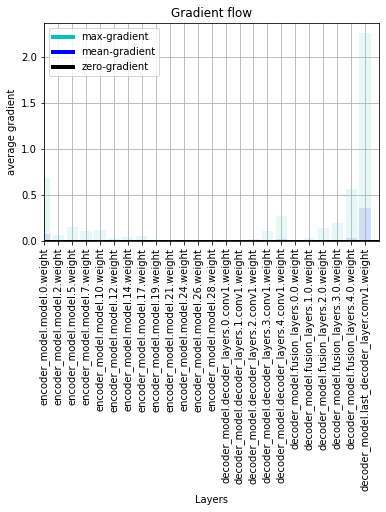

Iter: 460 | Train loss on last  20 : total - 15.241506195068359, content-23.506370067596436, style-12.890869158506394


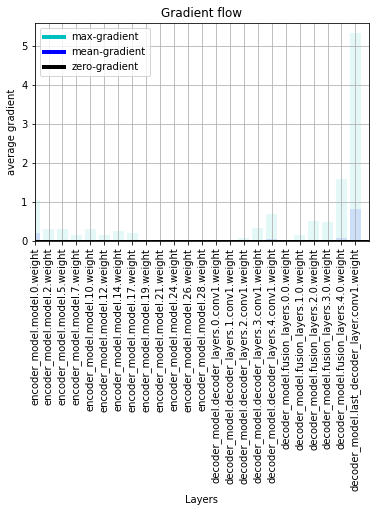

Iter: 480 | Train loss on last  20 : total - 17.07912794351578, content-27.148744773864745, style-14.36425331234932


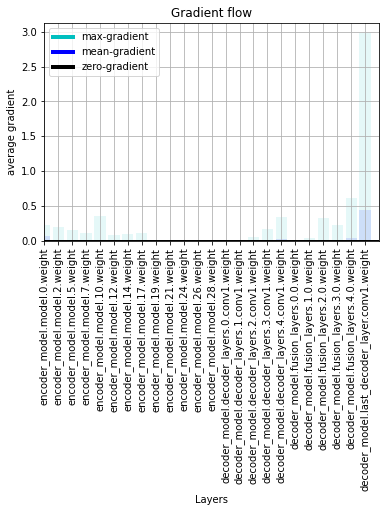

Iter: 500 | Train loss on last  20 : total - 21.853297555446623, content-23.393564987182618, style-19.51394087076187


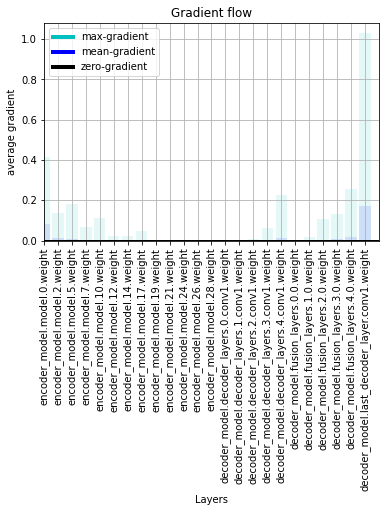

Iter: 520 | Train loss on last  20 : total - 15.808419036865235, content-26.337273120880127, style-13.174691760540009


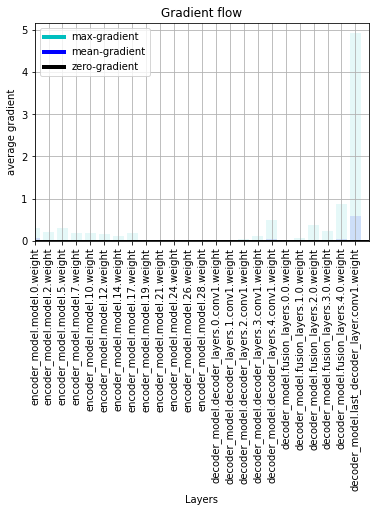

Iter: 540 | Train loss on last  20 : total - 17.13777458667755, content-27.10956802368164, style-14.42681759595871


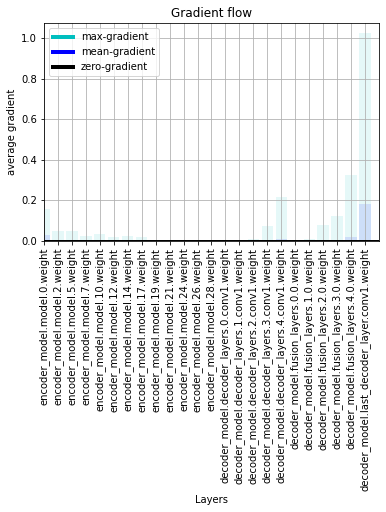

Iter: 560 | Train loss on last  20 : total - 19.625194132328033, content-26.224256706237792, style-17.002768397331238


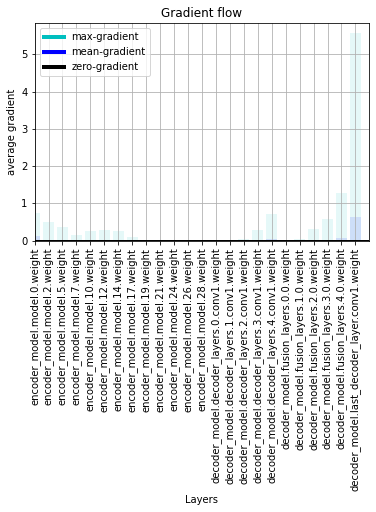

Iter: 580 | Train loss on last  20 : total - 14.799865114688874, content-25.326871633529663, style-12.267177712917327


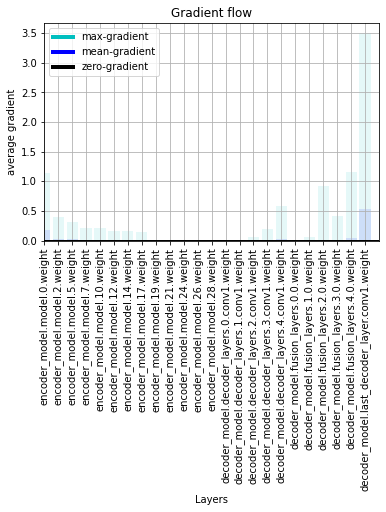

Iter: 600 | Train loss on last  20 : total - 14.300918793678283, content-20.754493999481202, style-12.225469338893891


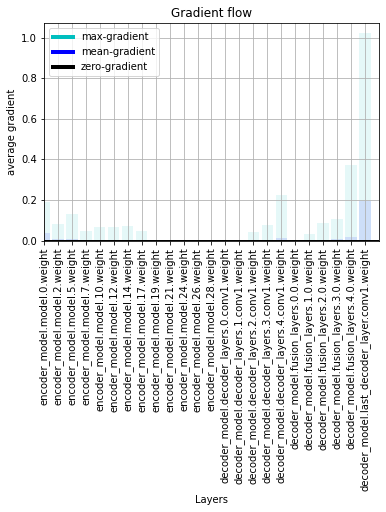

Iter: 620 | Train loss on last  20 : total - 12.803781890869141, content-22.762911748886108, style-10.527490675449371


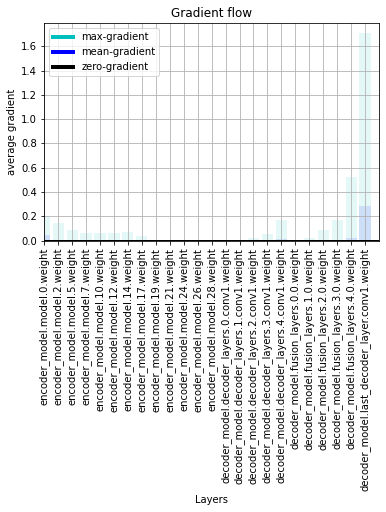

Iter: 640 | Train loss on last  20 : total - 15.560570776462555, content-23.570010375976562, style-13.203569620847702


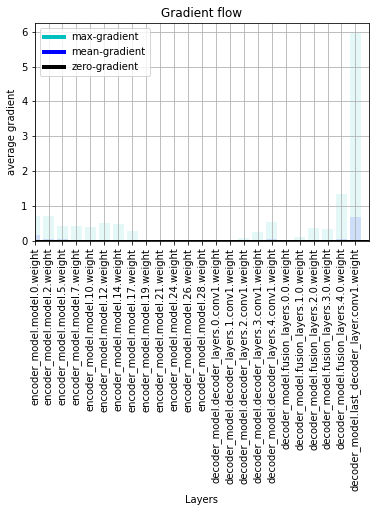

Iter: 660 | Train loss on last  20 : total - 17.598885452747346, content-25.730893564224242, style-15.02579618692398


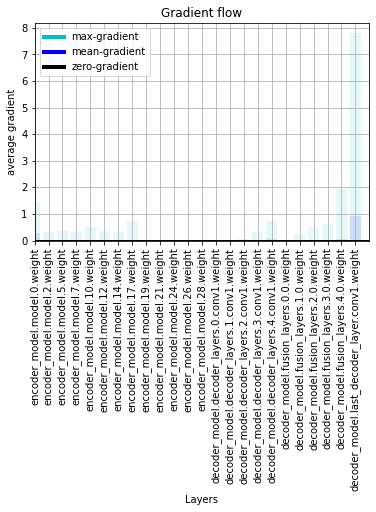

Iter: 680 | Train loss on last  20 : total - 15.85468236207962, content-21.931602048873902, style-13.661522060632706


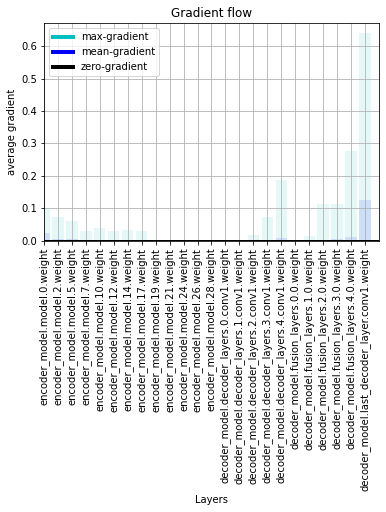

Iter: 700 | Train loss on last  20 : total - 16.091424822807312, content-26.053297138214113, style-13.486095213890076


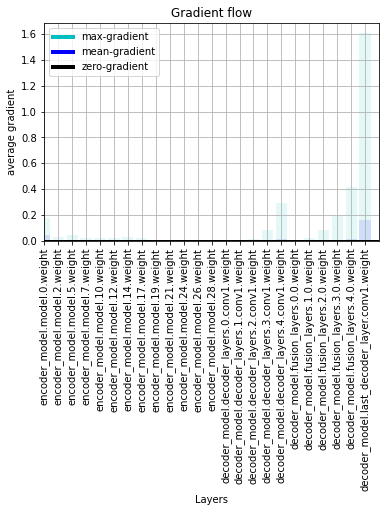

Iter: 720 | Train loss on last  20 : total - 16.33924617767334, content-26.01233615875244, style-13.738012623786926


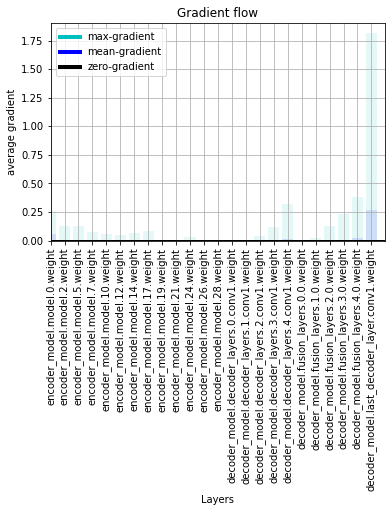

Iter: 740 | Train loss on last  20 : total - 14.707878112792969, content-25.425946712493896, style-12.165283459424973


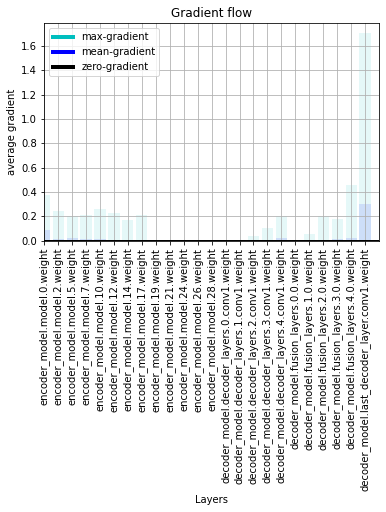

Iter: 760 | Train loss on last  20 : total - 12.667639017105103, content-24.453640079498292, style-10.222275030612945


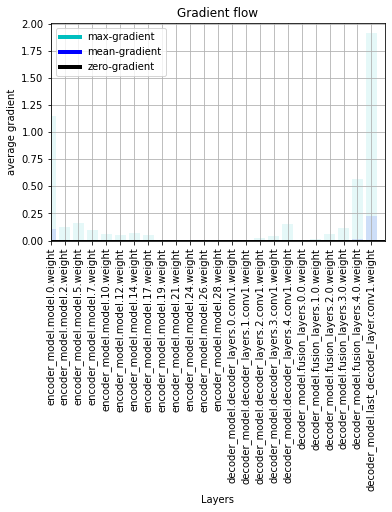

Iter: 780 | Train loss on last  20 : total - 10.581460213661193, content-23.83993625640869, style-8.197466617822647


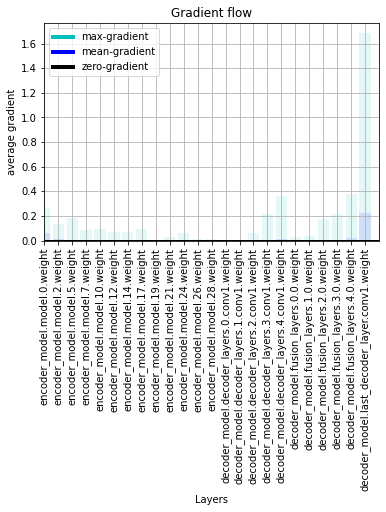

Iter: 800 | Train loss on last  20 : total - 24.92692151069641, content-30.72939338684082, style-21.853982251882552


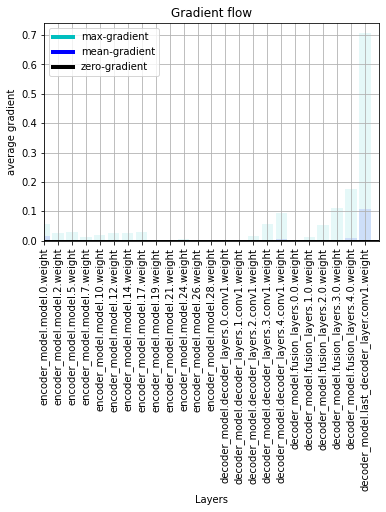

Iter: 820 | Train loss on last  20 : total - 19.101897525787354, content-27.6101282119751, style-16.340884572267534


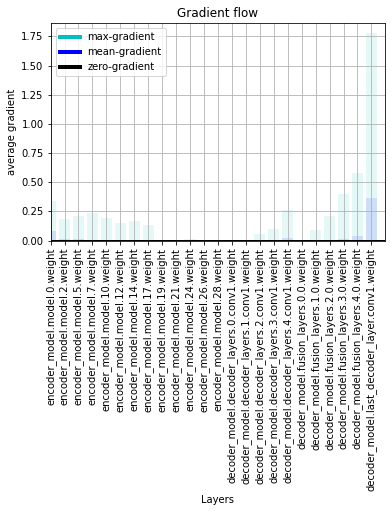

Iter: 840 | Train loss on last  20 : total - 12.322887206077576, content-26.700331497192384, style-9.652854061126709


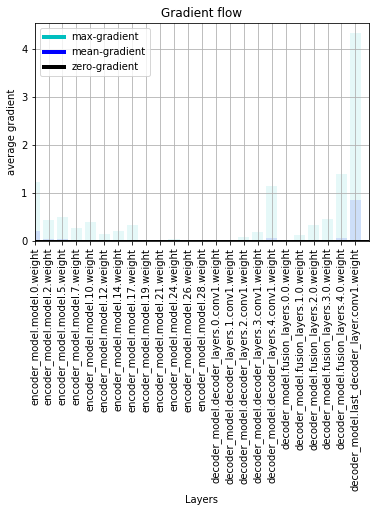

Iter: 860 | Train loss on last  20 : total - 16.412096071243287, content-27.534494352340698, style-13.6586465716362


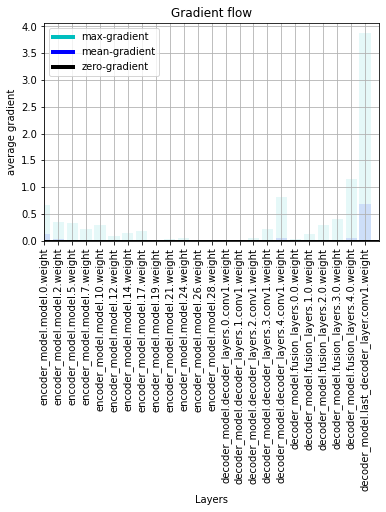

Iter: 880 | Train loss on last  20 : total - 16.394274616241454, content-28.163510608673096, style-13.577923542261123


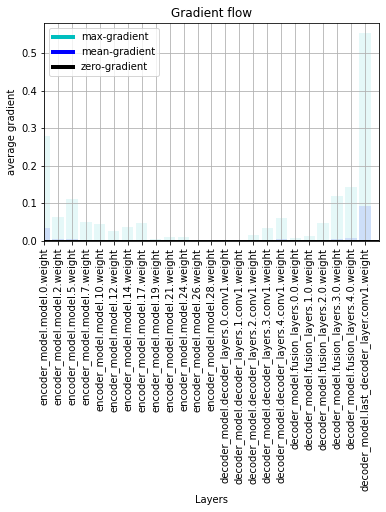

Iter: 900 | Train loss on last  20 : total - 8.699587571620942, content-26.449864864349365, style-6.054600971937179


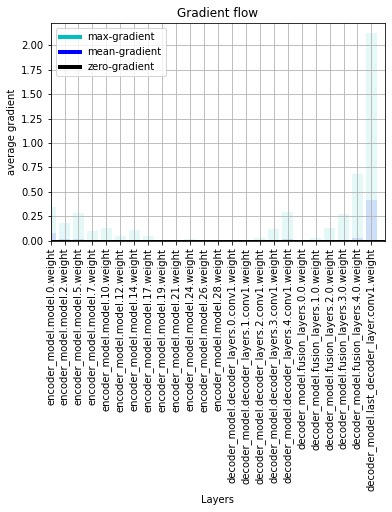

Iter: 920 | Train loss on last  20 : total - 15.686387705802918, content-27.40418920516968, style-12.945968782901764


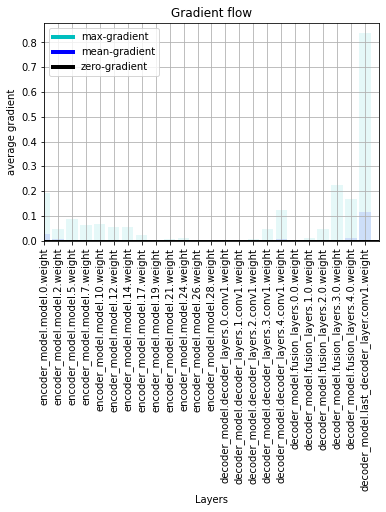

Iter: 940 | Train loss on last  20 : total - 11.414174699783326, content-23.796865463256836, style-9.034488022327423


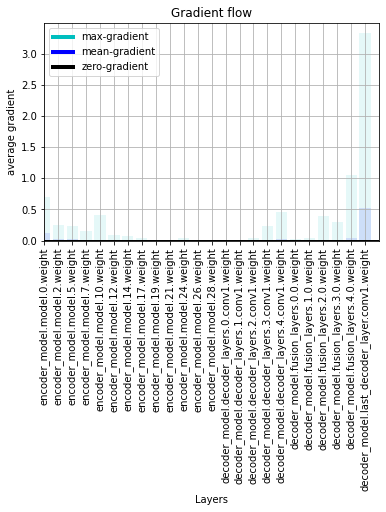

Iter: 960 | Train loss on last  20 : total - 12.696232748031616, content-25.18518853187561, style-10.177713799476624


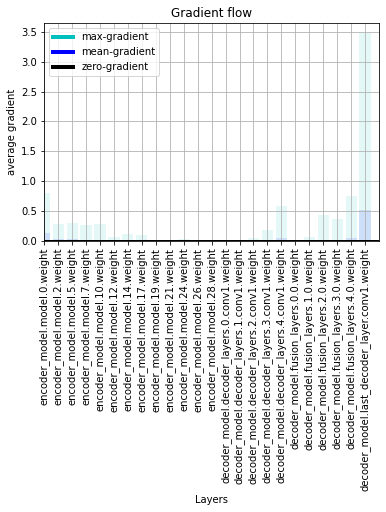

Iter: 980 | Train loss on last  20 : total - 13.962779307365418, content-28.136999988555907, style-11.149079132080079


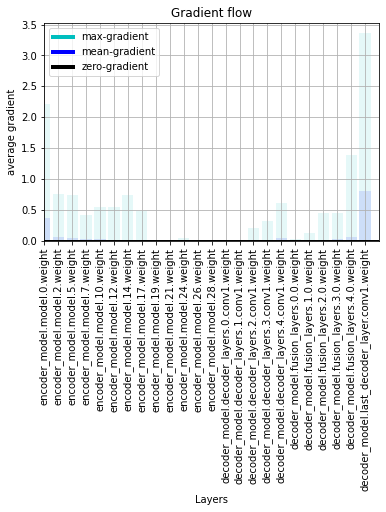

Iter: 1000 | Train loss on last  20 : total - 12.750417137145996, content-25.987692451477052, style-10.151647847890853


In [43]:
main_model.weights = [1 for i in range(len(main_model.weights))]

main_model, writer, grad_dict = train(main_model,
                                    Adam,
                                    dataset_train,
                                    loss_model,
                                    1000,
                                    batch_size=3,
                                    lr=1e-4,
                                    out_frequency=20,
                                    alpha=0.1)

In [44]:
#main_model

In [45]:
#list(main_model.named_parameters())

In [46]:
#list(main_model.weights.named_parameters())

In [47]:
#w = [torch.clone(w.data) for w in main_model.weights]
#w

In [48]:
#main_model.weights[1].data = torch.zeros(1).to(DEVICE)
#main_model.weights[0].data

In [49]:
#resnet = nn.Sequential(od)
##adain = AdainBlock(LAYERS_NAME)
#decoder = DecoderBlock(CHANNELS_SIZES)


#main_model = STUNet(vgg, adain, decoder, LAYERS_NAME, CHANNELS_SIZES)

In [50]:

name = "Vgg16_512_top_model.pth"
torch.save(main_model.state_dict(), name)
main_model.load_state_dict(torch.load(name))
main_model = main_model.to(DEVICE)
main_model = main_model.eval()


In [51]:
#main_model


In [52]:
torch.cuda.empty_cache()

contents, styles = dataset_test[10]
contents_t, styles_t = torch.unsqueeze(contents, 0).to(DEVICE), torch.unsqueeze(styles, 0).to(DEVICE)
main_model.weights = [1, 1,  1, 1, 1, 1, 1]

In [53]:
print(main_model.weights)

[1, 1, 1, 1, 1, 1, 1]


In [54]:
%%time
with torch.no_grad():
    out_img = main_model(normalize(contents_t), normalize(styles_t))[0]

CPU times: user 9.58 ms, sys: 0 ns, total: 9.58 ms
Wall time: 9.72 ms


In [55]:
#out_img = (out_img - torch.min(out_img)) / (torch.max(out_img)- torch.min(out_img))
#print(torch.max(out_img), torch.min(out_img))
#print(out_img.shape, contents.shape)


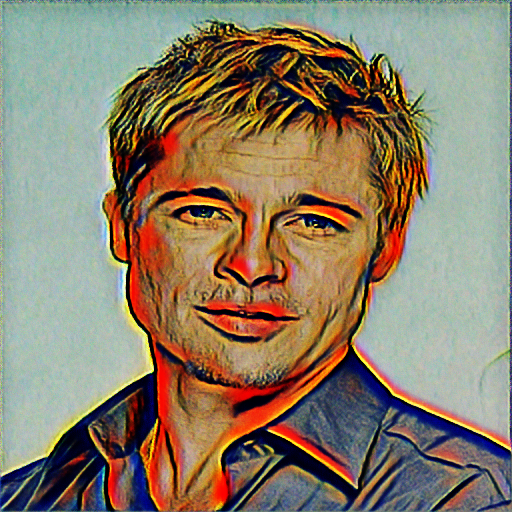

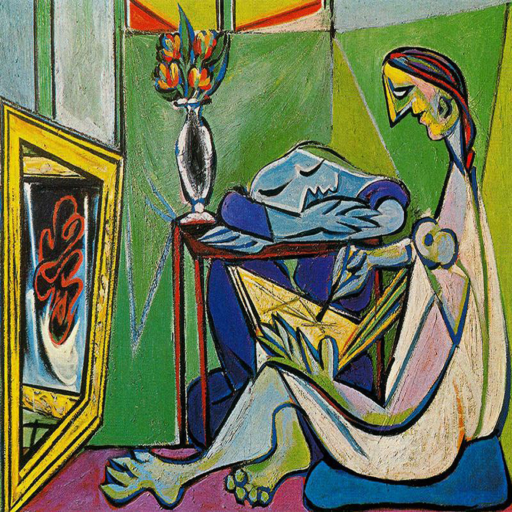

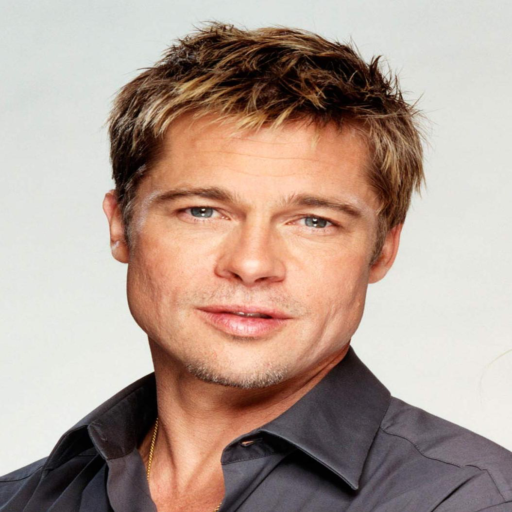

In [56]:
from IPython.display import display # to display images
pil_out_img = transforms.ToPILImage()(out_img.detach())
pil_styles = transforms.ToPILImage()(styles)
pil_contents = transforms.ToPILImage()(contents)


import matplotlib.pyplot as plt

#plt.imshow(np.asarray(pil_img))
#plt.show()
#imshow(np.asarray(pil_styles))
#plt.show()
#imshow(np.asarray(pil_contents))
#plt.show
display(pil_out_img)
display(pil_styles)
display(pil_contents)

In [57]:
# save_results
import os
from skimage.io import imread, imsave
def apply_styles(model, test_dataset, save_directory, weights):

    if hasattr(model, 'weights'):
        model.weights = weights
    else:
        "Your model doesn't have controlling parameters!"
    
    os.makedirs(save_directory, exist_ok=True)

    num_images = len(test_dataset)
    weights_str = '_'.join([str(w) for w in weights])
    with torch.no_grad():
        for i in range(num_images):
            content, style = test_dataset[i]
            content_name, style_name = test_dataset.get_names(i)
            content_name = os.path.splitext(os.path.basename(content_name))[0]
            style_name = os.path.splitext(os.path.basename(style_name))[0]

            content, style = torch.unsqueeze(content, 0), torch.unsqueeze(style, 0)
            content, style = content.to(DEVICE), style.to(DEVICE)
            content, style = normalize(content), normalize(style)

            out = model(content, style)

            out_pil = transforms.ToPILImage()(out.detach()[0])

            imsave(
                os.path.join(save_directory, "{}_{}_{}.png".format(weights_str,
                                                                   content_name,
                                                                   style_name
                                                                   )),
                np.asarray(out_pil))

In [58]:
weights = [0.1, 0.1, 0.1, 1, 1, 1]
apply_styles(main_model, dataset_test, "Unet_512", weights)

In [59]:
#name = 'unet_model_normal_vgg.pth'
#torch.save(main_model.state_dict(), name)

In [60]:
import copy 

def generate_all_possible(model, test_dataset, save_dir, step=0.25, weights):
    if not sum(weights):
        return 

    apply_styles(model, test_dataset, )
    for i in range(len(weights)):
        weights_copy = copy.deepcopy(weights)
        weights_copy[i] -= step
        generate_all_posible(model, test_dataset, save_dir, step, weights_copy)

        

SyntaxError: ignored

In [ ]:
t = torch.Tensor([[1, 2], [3, 4]])
print(torch.mean(t, (1), keepdims=True))

In [ ]:
p = nn.Parameter(torch.randn(1))

In [ ]:
p.data.item()

In [ ]:
a = torch.randn(2, 54, 224, 224)
a = a.view(2, 54, -1)

In [ ]:
a.shape

In [ ]:
#debug tool for gradients value checking
from graphviz import Digraph
import torch
from torch.autograd import Variable, Function

def iter_graph(root, callback):
    queue = [root]
    seen = set()
    while queue:
        fn = queue.pop()
        if fn in seen:
            continue
        seen.add(fn)
        for next_fn, _ in fn.next_functions:
            if next_fn is not None:
                queue.append(next_fn)
        callback(fn)

def register_hooks(var):
    fn_dict = {}
    def hook_cb(fn):
        def register_grad(grad_input, grad_output):
            fn_dict[fn] = grad_input
        fn.register_hook(register_grad)
    iter_graph(var.grad_fn, hook_cb)

    def is_bad_grad(grad_output):
        if grad_output is None:
            return False
        return grad_output.isnan().any() or (grad_output.abs() >= 1e6).any()

    def make_dot():
        node_attr = dict(style='filled',
                        shape='box',
                        align='left',
                        fontsize='12',
                        ranksep='0.1',
                        height='0.2')
        dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

        def size_to_str(size):
            return '('+(', ').join(map(str, size))+')'

        def build_graph(fn):
            if hasattr(fn, 'variable'):  # if GradAccumulator
                u = fn.variable
                node_name = 'Variable\n ' + size_to_str(u.size())
                dot.node(str(id(u)), node_name, fillcolor='lightblue')
            else:
                assert fn in fn_dict, fn
                fillcolor = 'white'
                if any(is_bad_grad(gi) for gi in fn_dict[fn]):
                    fillcolor = 'red'
                dot.node(str(id(fn)), str(type(fn).__name__), fillcolor=fillcolor)
            for next_fn, _ in fn.next_functions:
                if next_fn is not None:
                    next_id = id(getattr(next_fn, 'variable', next_fn))
                    dot.edge(str(next_id), str(id(fn)))
        iter_graph(var.grad_fn, build_graph)

        return dot

    return make_dot

x = torch.randn(10, 10, requires_grad=True)
y = torch.randn(10, 10, requires_grad=True)

z = x / (y * 0)
z = z.sum() * 2
get_dot = register_hooks(z)
z.backward()
dot = get_dot()
dot # in Jupyter, you can just render the variable



In [ ]:
a = torch.Tensor([[[1,2],
                  [3, 4]]])
a.shape

In [ ]:
a.mean(dim=(-1,-2), keepdims=True)

In [ ]:
#def fuse_two_nets(net1, net2, alpha):



In [ ]:

    #normalize = nn.Sequential(transforms.Normalize(mean=, , ],
    #                             std=[0.229, 0.224, 0.225]))

In [ ]:
example = torch.randn(2, 3, 256, 256)

In [ ]:
(example - mu ) / std